In [2]:
import numpy as np
import glob
from PTMCMCSampler import PTMCMCSampler

import scipy
import scipy.stats
from scipy.integrate import odeint
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from numba import jit
from matplotlib import cm
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import timeit

Do not have mpi4py package.


Text(0.5, 1.0, 'Cumulative deaths Elyam, UK 1666')

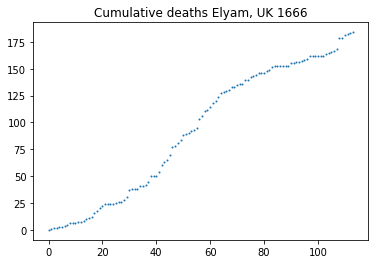

In [4]:
def SIR( X, t,  alpha, beta, I0  ):
    dSdt= -beta* X[0] * X[1]
    dIdt= beta*X[0] * X[1]- alpha*X[1]
    dRdt= alpha*X[1]
    return np.array( [   dSdt, dIdt, dRdt   ]   )
    

data = pd.read_csv("Eyam_time_SIR.csv") 
data.index
y=np.append(0, pd.Series.to_numpy(data.iloc[:, 3])) #cumulative deaths 
x=pd.Series.to_numpy(data.iloc[ 111:114 , 2 ])
n=len(y)        
ts=np.arange(0,len(y),1 )


plt.scatter( ts,y, s=1)
plt.title('Cumulative deaths Elyam, UK 1666')

In [13]:
''' Second black plague outbreak in Elyam, UK 
    June 19, 1666 to Nov 1, 1666 (Massel et al 2004)
    114 days
    The village had been quarantined so the population
    is fixed to N=261. 
    
    States: 
        S(t): susceptible
        I(t): infected
        R(t): removed
        N=S(t)+I(t)+R(t)
    obs: once you get the plague you never recover, you die 
    
    '''
    

def Analysis(x):
    mean=np.mean(x,0)
    median=np.median(x,0)
    var=np.var(x,0)

    ess=np.zeros( x.shape[1])
    for i in range( x.shape[1] ):
      ess[i]=tfp.mcmc.effective_sample_size(  x[:,i] , filter_beyond_positive_pairs=True)
    
    mess=np.min(ess)

    summary= {
        "Mean": mean,
        "Median":median,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        "mess":mess, #min ess

        }
    return summary

Text(0.5, 1.0, 'Cumulative deaths Elyam, UK 1666')

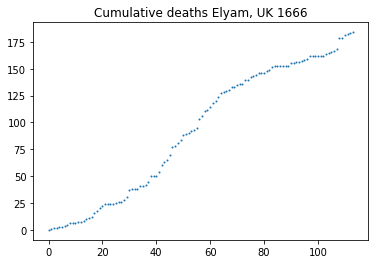

In [14]:
def SIR( X, t,  alpha, beta, I0  ):
    dSdt= -beta* X[0] * X[1]
    dIdt= beta*X[0] * X[1]- alpha*X[1]
    dRdt= alpha*X[1]
    return np.array( [   dSdt, dIdt, dRdt   ]   )
    
N=261 #Total population   
data = pd.read_csv("Eyam_time_SIR.csv") 
data.index
y=np.append(0, pd.Series.to_numpy(data.iloc[:, 3])) #cumulative deaths 
x=pd.Series.to_numpy(data.iloc[ 111:114 , 2 ])
n=len(y)        
ts=np.arange(0,len(y),1 )


plt.scatter( ts,y, s=1)
plt.title('Cumulative deaths Elyam, UK 1666')

In [28]:


    


class PT_target(object):
    
    def logL(self,Theta):
        alpha=Theta[0]
        beta=Theta[1]
        I0=Theta[2]
        n=len(y)
        X0=np.array( [N-I0, I0, 0] )
        Xt = odeint( SIR, X0, ts, args=(alpha,beta,I0,))  
        It= Xt[:,1]
        It[It<0]=0
        Rt=Xt[:,2]
        Rt[Rt>261]=261
        ll=0
        ll=ll+np.log( It[n-2]/N +1e-300 )+(N-1)*np.log( 1- It[n-2]/N    )+N*np.log( 1- It[n-1]/N  )
        ll=ll+ np.sum(y[1:n]* np.log( Rt[1:] /N ))+np.sum( (N-y[1:])  *np.log(   1- Rt[1:]/N +1e-300 ))
        return ll


    
    
    def log_prior(self,Theta):
        alpha=Theta[0]
        beta=Theta[1]
        I0=Theta[2]
        if( alpha>0 and beta>0 and alpha<1 and beta<1 and I0>=1 and I0<=10  ):
             a= -alpha-beta+I0*np.log( 5/N )+(N-I0)*np.log( 1- 5/N   )
             b=scipy.special.loggamma(N+1)- scipy.special.loggamma(I0+1)- scipy.special.loggamma(N-I0+1)
             return a+b
        else:
             return -np.inf
    

def p0(): 
    a=scipy.stats.uniform.rvs(0, 0.0008 , 1)
    b= scipy.stats.uniform.rvs(0, 0.0008 , 1)
    c=scipy.stats.uniform.rvs(1,9, 1)
   
    return np.array([a[0],b[0],c[0]])






In [30]:
f=PT_target()
cov=np.diag([ 1/2,1/2,1/2])
dim=3
T=500000
bi=int(0.15*T)


sampler = PTMCMCSampler.PTSampler(dim, f.logL , f.log_prior, np.copy(cov), outDir='PTcaseBLACKPLAGUE/chains', resume=False)


initpoint=p0()
sampler.sample(initpoint, T, burn= bi  , thin=1, covUpdate=1000,
               SCAMweight=30, AMweight=20, DEweight=50, HMCweight=0, HMCsteps=0)
   
    
data = np.loadtxt('PTcaseBLACKPLAGUE/chains/chain_1.txt') #if T is changed be sure to create new directory for chain
PTchain = data[:,:-4]
    
    
   

Finished 15.00 percent in 102.063972 s Acceptance rate = 0.0151467Adding DE jump with weight 50
Finished 99.80 percent in 640.158812 s Acceptance rate = 0.1722959
Run Complete


In [38]:
Adata=Analysis(PTchain[bi:])
Adata

{'Mean': array([1.38102773e-02, 6.90630483e-04, 9.72510675e+00]),
 'Median': array([1.38080824e-02, 6.89519423e-04, 9.80174781e+00]),
 'Variance': array([8.86219529e-08, 6.73518826e-10, 6.72319648e-02]),
 'mVar': array([1.27560415e-11, 9.35347826e-14, 1.17382881e-05]),
 'ess': array([6947.44941617, 7200.73118333, 5727.57835297]),
 'mess': 5727.578352969361}

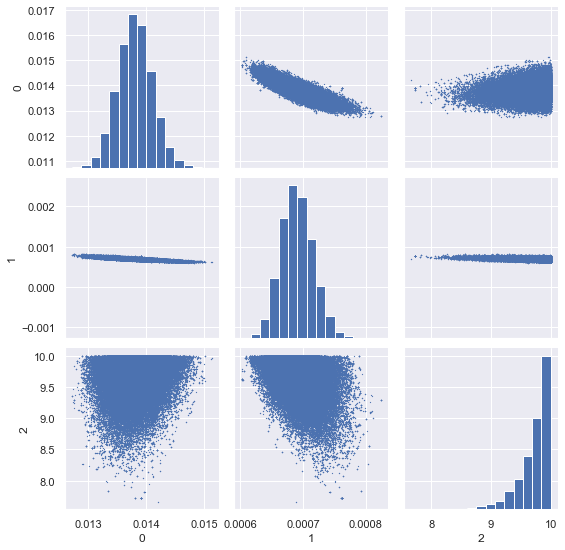

In [39]:
results=pd.DataFrame( PTchain[bi:])
sns.set()
sns.pairplot(results, markers='.', plot_kws=dict(s=1, edgecolor="b"),diag_kws=dict(bins=15) )
plt.savefig('PTpairplotBlackPlague', dpi=500)

In [34]:

def predobs( alpha, beta, I0s, tup=136  ,sample_size=150 ):
    L=len(alpha)
    obs=np.zeros([ sample_size  , tup]) 
    
    SSts=np.zeros([ sample_size  , tup]) 
    IIts=np.zeros([ sample_size  , tup]) 
    RRts=np.zeros([ sample_size  , tup]) 
    
    ts=np.arange(0,tup, 1)
    
    #sample of size sample_size of betas and I0s. 
    #which observations to take into account for the predictive
    indexes=np.random.choice(a = np.arange( 0, L )   , size = sample_size, replace = False)
    
    salphas=alpha[indexes]
    sI0s= I0s[indexes]
    sbetas= beta[indexes]
    for i in range(sample_size ):
        X0=np.array( [N-I0s[i], I0s[i], 0] )
        Xt=scipy.integrate.odeint( SIR, X0, ts, args=(salphas[i],sbetas[i],sI0s[i],) ) 
        It=Xt[:,1]
        It[It<0]=0
        Rt=Xt[:,2]
        Rt[Rt>261]=261
        
        SSts[i]=Xt[ :,0]
        IIts[i]=Xt[ :,1]
        RRts[i]=Xt[ :,2]
        obs[i]=scipy.stats.binom.rvs( n=N, p= Rt/N )
        
    return SSts, IIts, RRts,  obs

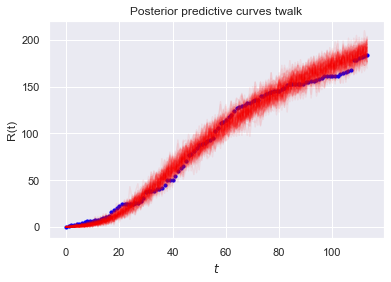

In [37]:
SSts, IIts, RRts,  obspred=predobs( PTchain[bi:,0] , PTchain[bi:,1] , PTchain[bi:,2]   , tup=114, sample_size=300)

indexes=np.random.choice(a = np.arange( 0,  obspred.shape[0] ), size =100, replace = False)
obs_samples=obspred[indexes]

SSts_samples=SSts[indexes]
IIts_samples=IIts[indexes]

for i in range( len(obs_samples )  ):
    plt.plot(obs_samples[i], color='red' , alpha=0.07 )

plt.scatter(ts,y, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'Posterior predictive curves twalk' )
plt.savefig( 'twalkRtBlackPlague.pdf', dpi=500  )
plt.show()

#It works :)
